In [1]:
import utils_BudykoSellers
import utils_emulator
import numpy as np

%load_ext autoreload
%autoreload 2

## Experiment 1: Coupled Three Box (memory effects)

This notebook runs the coupled three box model for the following scenarios and emulation techniques:

Scenarios:
1. Abrupt - An abrupt doubling of CO2 concentration; corresponds roughly to the *Abrupt2xCO2* CMIP experiment.
2. High Emissions - An exponential increase of CO2 concentration in time; corresponds roughly to *SSP585*.
3. Plateau - An increase in CO2 concentration in time that follows a hyperbolic tangent, increasing exponentially and then tapering off; corresponds roughly to *SSP245*.
4. Overshoot - An increase in CO2 concentration in time that follows a Gaussian profile, increasing and decreasingly rapidly; inspired by *SSP119*, but decreases more quickly.

Emulators:
1. Pattern Scaling - Time-invariant pattern based on linear regression from global mean temperature to local temperature.
2. Fluctuation Dissipation Theorem - Response functions derived through perturbation experiment.
3. Deconvolution - Response functions solved for from any general experiment.
4. Modal Fitting - Response functions fit from any general experiment.
5. Dynamic Mode Decomposition (DMD) - Approximating system dynamics with a linear operator.
6. Extended DMD - Approximating system dynamics with nonlinear basis functions.

Note: For this linear system, there is no increase in performance using EDMD with a higher-order basis. Both methods give identical results in this notebook.

### Setup and Run Scenarios

Required before creating/evaluating emulators.

In [2]:
# Required variables
t_end = 251
t = np.arange(0,t_end)
n_boxes = 3

# Initialize forcing vectors and run scenarios
scenarios = ['Abrupt','High Emissions','Plateau','Overshoot']
forcings, full_outputs, T_out = {}, {}, {}
for i, scen in enumerate(scenarios):
  full_outputs[scen] = utils_BudykoSellers.Run_Budyko_Sellers(scen_flag=i, n_boxes=n_boxes, diff_flag=1)
  forcings[scen] = np.tile(full_outputs[scen]['forcing_ts'], (n_boxes, 1))
  T_out[scen] = np.squeeze(full_outputs[scen]['T_ts'])[0:n_boxes,:]

/Users/chriswomack/Documents/PhD/Project 1/utils_BudykoSellers.py:346: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


### Method I: Pattern Scaling

Train: Abrupt - NRMSE
	Test: Abrupt - [24.07873474 10.27400645 12.06507009]
	Test: High Emissions - [101.55688346  25.41154022  22.40953554]
	Test: Mid. Emissions - [58.78356231 15.71072342 17.75471815]
	Test: Overshoot - [69.88789915 19.15326042 21.45126926]
Train: High Emissions - NRMSE
	Test: Abrupt - [47.82075779 21.57777749 20.35181441]
	Test: High Emissions - [1.24098892 0.31682112 0.33429723]
	Test: Mid. Emissions - [36.42713814 12.67325934  7.06650445]
	Test: Overshoot - [50.50049311 18.40119311  9.46449925]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [36.55935569 14.99611341 18.06584895]
	Test: High Emissions - [33.95652344 10.78604116  4.03788142]
	Test: Mid. Emissions - [24.70474208  7.62132355  6.04844542]
	Test: Overshoot - [42.68867454 14.14541575  9.61084454]
Train: Overshoot - NRMSE
	Test: Abrupt - [36.75739885 14.28314894 19.41620699]
	Test: High Emissions - [33.31141416 12.12650518  1.64392856]
	Test: Mid. Emissions - [24.70999039  7.72467989  6.43354098]
	Test: Ove

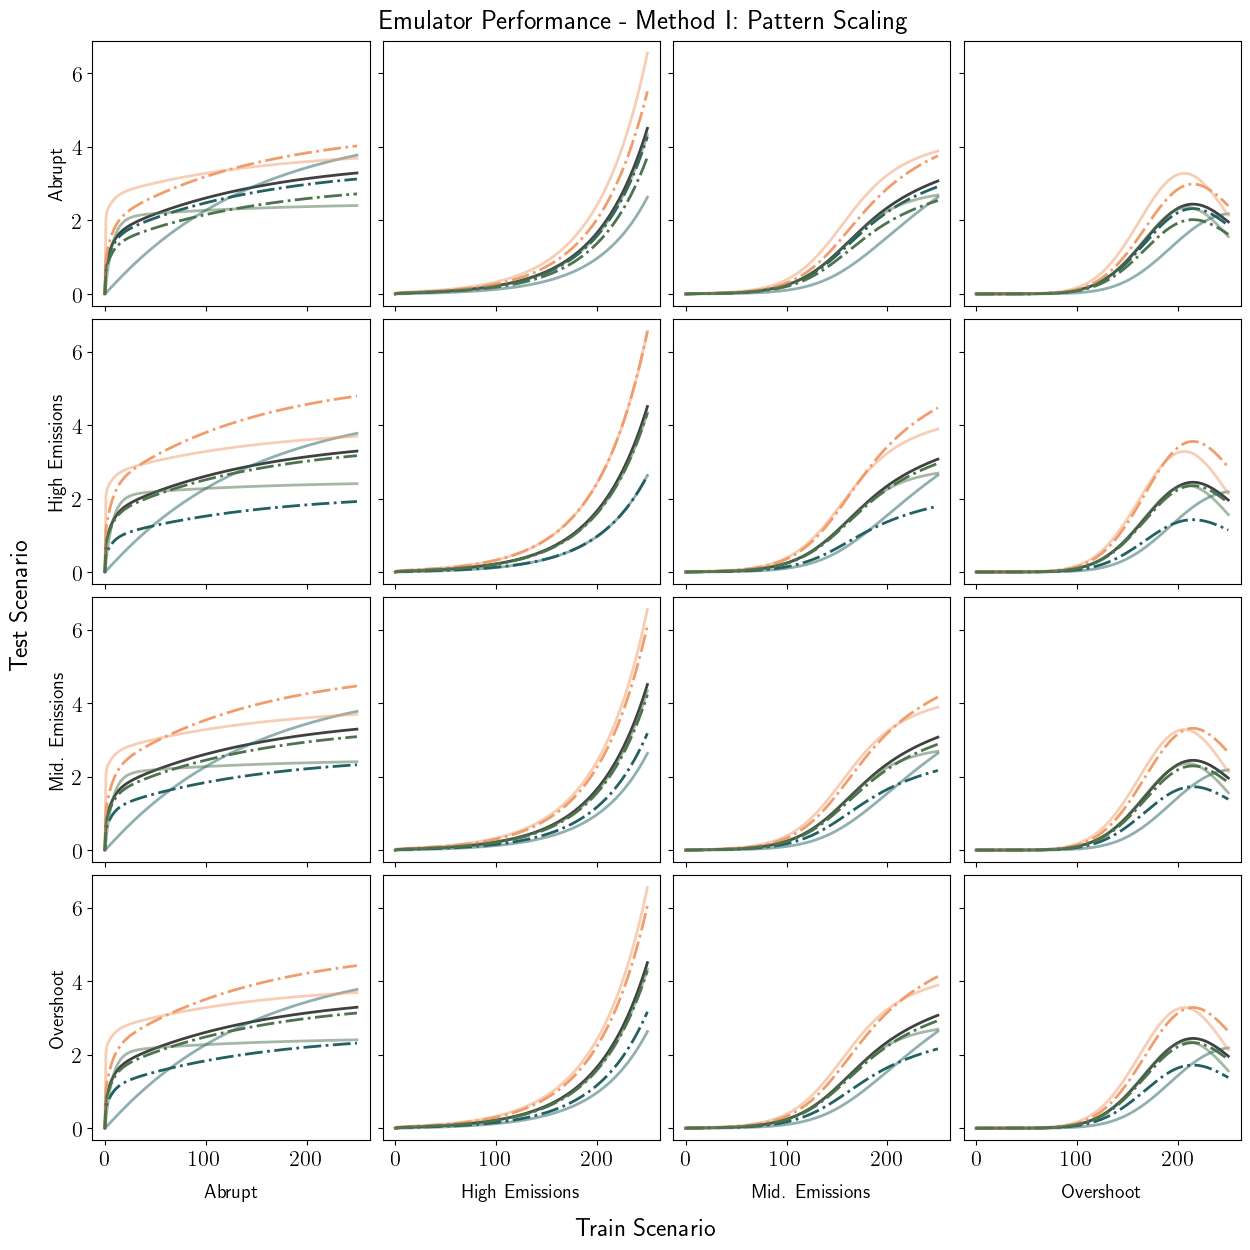

In [4]:
verbose    = True   # Show error output
plot       = True   # Plot emulator performance
save_error = False  # Save error output

operator_PS, T_pred_PS, error_metrics_PS = utils_emulator.emulate_scenarios('PS', scenarios=scenarios, outputs=T_out, forcings=forcings, verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_PS, scenarios, operator='PS')

if save_error:
  utils_emulator.save_results(error_metrics_PS, 'exp1_I_PS_error')

### Method II: Fluctuation Dissipation Theorem

Train: Impulse Forcing - NRMSE
	Test: Abrupt - [0.60287314 1.23075625 0.57420219]
	Test: High Emissions - [0.73692487 0.04303795 0.71992374]
	Test: Mid. Emissions - [0.39812525 1.28013608 0.55702586]
	Test: Overshoot - [0.66416851 2.01107919 1.18795892]
Average error for Abrupt: 0.8026105273781695
Average error for High Emissions: 0.4999621863304431
Average error for Mid. Emissions: 0.7450957263056247
Average error for Overshoot: 1.2877355406288375


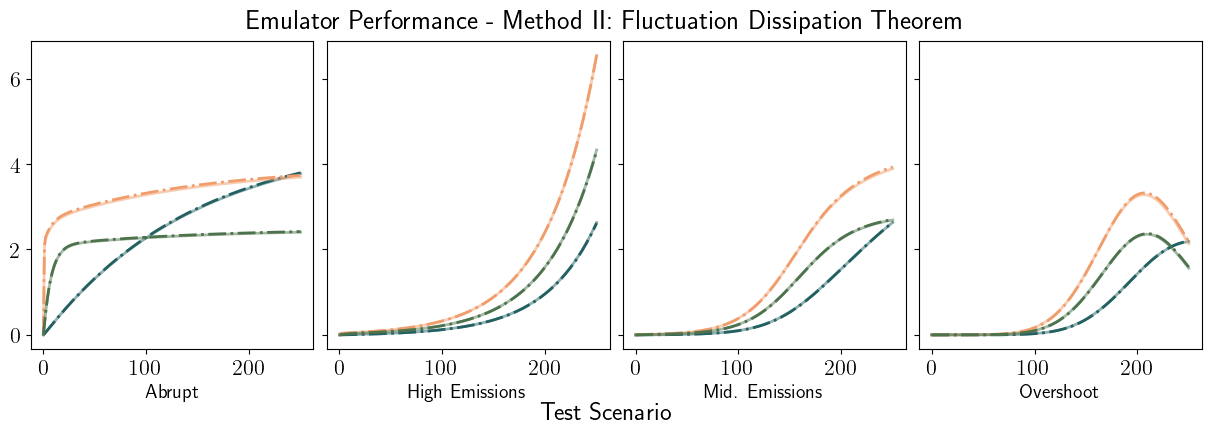

In [33]:
verbose    = True    # Show error output
plot       = True    # Plot emulator performance
save_error = False   # Save error output

dt = 1 # Timestep (year)
operator_FDT, T_pred_FDT, error_metrics_FDT = utils_emulator.emulate_scenarios('FDT', scenarios=scenarios, outputs=T_out, forcings=forcings, n_boxes=n_boxes, dt=dt, diff_flag=1, delta=1, verbose=verbose)

for test in scenarios:
  print(f'Average error for {test}: {np.mean(error_metrics_FDT[test])}')

if plot:
  utils_emulator.plot_true_pred_FDT(T_out, T_pred_FDT, scenarios)

if save_error:
  utils_emulator.save_results(error_metrics_FDT, 'exp1_II_FDT_error')

### Method III: Deconvolution

Train: Abrupt - NRMSE


/Users/chriswomack/anaconda3/envs/research/lib/python3.13/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


	Test: Abrupt - [0.00870026 0.55338802 0.08514629]
	Test: High Emissions - [1.60353175 2.06132796 1.6134458 ]
	Test: Mid. Emissions - [1.01966122 0.86539438 0.7117911 ]
	Test: Overshoot - [1.08401654 1.29931731 1.04552527]
Train: High Emissions - NRMSE
	Test: Abrupt - [ 7.82507841 25.4305132  19.89506827]
	Test: High Emissions - [0.23337449 0.49228286 0.35980304]
	Test: Mid. Emissions - [ 4.69666033 23.78316912 17.1705537 ]
	Test: Overshoot - [ 6.25998374 37.43170032 26.24193865]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [10.98511292  9.06523596  2.74493349]
	Test: High Emissions - [1.49042759 2.32882398 0.81566663]
	Test: Mid. Emissions - [0.08998156 0.55526513 0.2321094 ]
	Test: Overshoot - [0.65829669 1.50373493 0.59668245]
Train: Overshoot - NRMSE
	Test: Abrupt - [14.61777274 13.66757471  3.322715  ]
	Test: High Emissions - [2.62694843 2.48387268 0.57150303]
	Test: Mid. Emissions - [1.05070123 0.84752349 0.1563903 ]
	Test: Overshoot - [0.06432249 0.35793509 0.10998116]


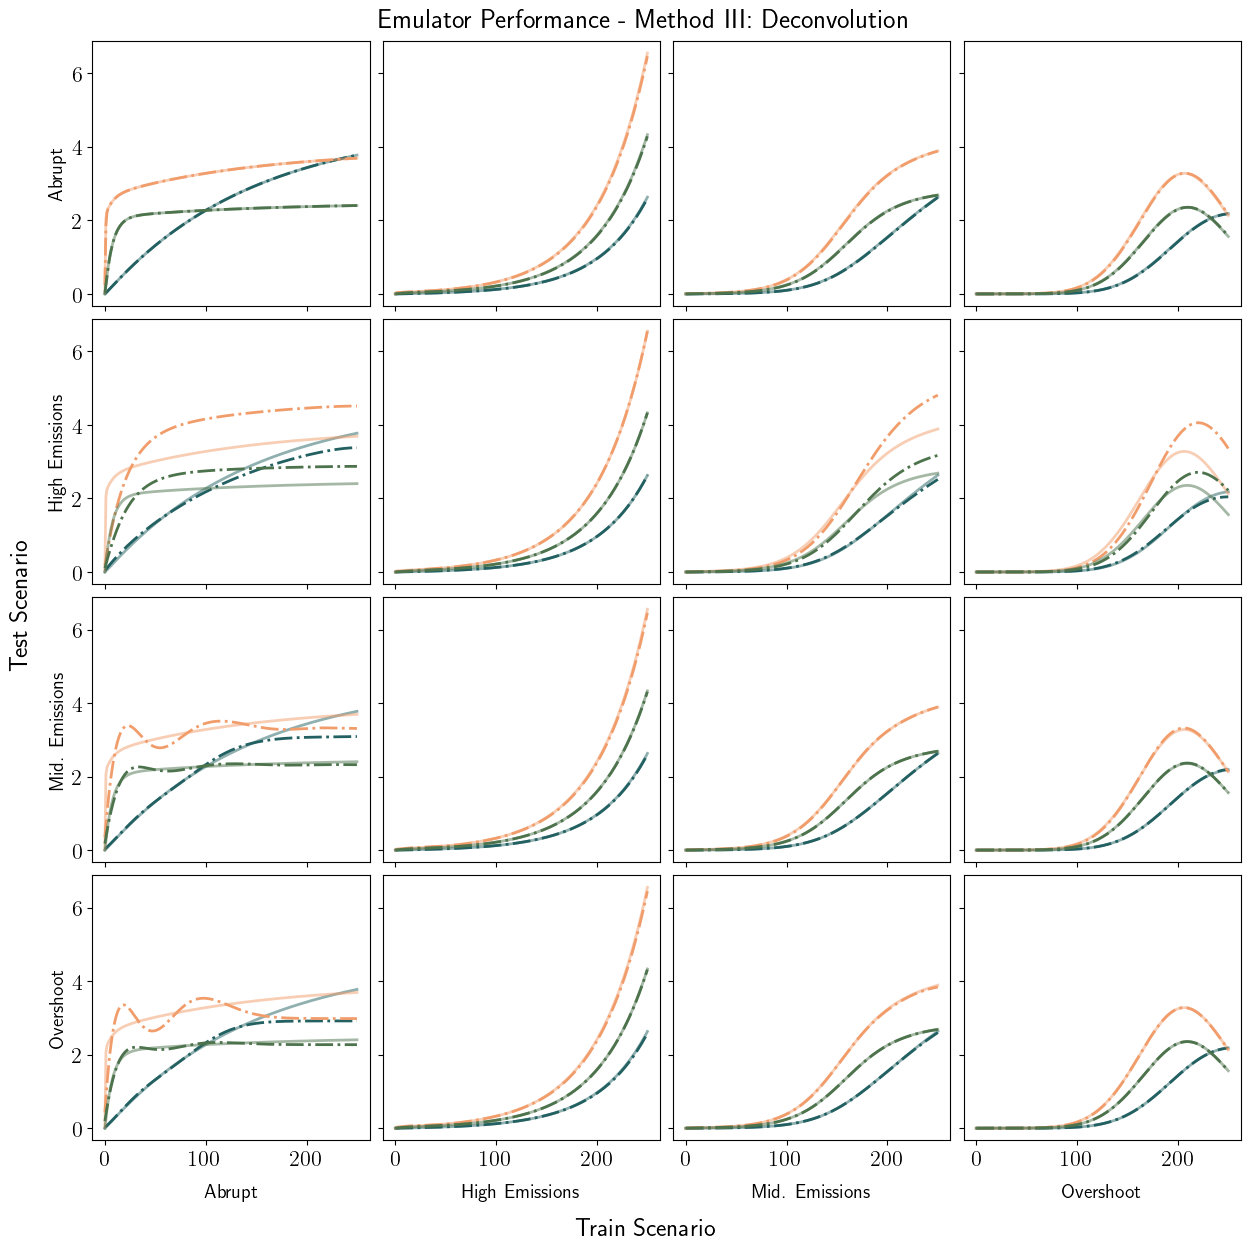

In [6]:
verbose    = True   # Show error output
plot       = True   # Plot emulator performance
save_error = False  # Save error output

dt = 1 # Timestep (year)
operator_deconvolve, T_pred_deconvolve, error_metrics_deconvolve = utils_emulator.emulate_scenarios('deconvolve', scenarios=scenarios, outputs=T_out, forcings=forcings, dt=dt, regularize=True, verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_deconvolve, scenarios, operator='deconvolve')

if save_error:
  utils_emulator.save_results(error_metrics_deconvolve, 'exp1_III_deconv_error')

### Method IV: Modal Fitting

Train: Abrupt - NRMSE
[  4.7785864  -13.721797   -12.584929    -6.0184097    0.35149506
 -10.641099    -8.476937   -12.627642     2.6281273   -5.031826
  -0.37985313  -2.1618395 ]
	Test: Abrupt - [0.88535397 2.17674595 3.11367527]
	Test: High Emissions - [0.40218193 0.41278844 2.94465796]
	Test: Mid. Emissions - [0.34110959 0.88416685 1.35988824]
	Test: Overshoot - [0.45226651 1.50836544 1.28659025]
Train: High Emissions - NRMSE
[  5.009265  -13.833307  -13.624374  -10.07894     1.2629383 -11.128966
 -11.246018  -13.200018    3.68938    -6.93439    -1.2308711  -3.59517  ]
	Test: Abrupt - [30.46843405 10.98359755 36.16211258]
	Test: High Emissions - [0.99728756 1.35457759 0.73540513]
	Test: Mid. Emissions - [ 6.74295835  3.52410494 27.72561002]
	Test: Overshoot - [ 8.32802898  4.58605011 41.27604251]
Train: Mid. Emissions - NRMSE
[  4.817085  -13.808358  -13.5393715  -6.748944    1.3199018 -11.217841
 -11.048016  -13.0796585   2.7584748  -5.212266   -1.216291   -2.3095884]
	Test: Abrupt

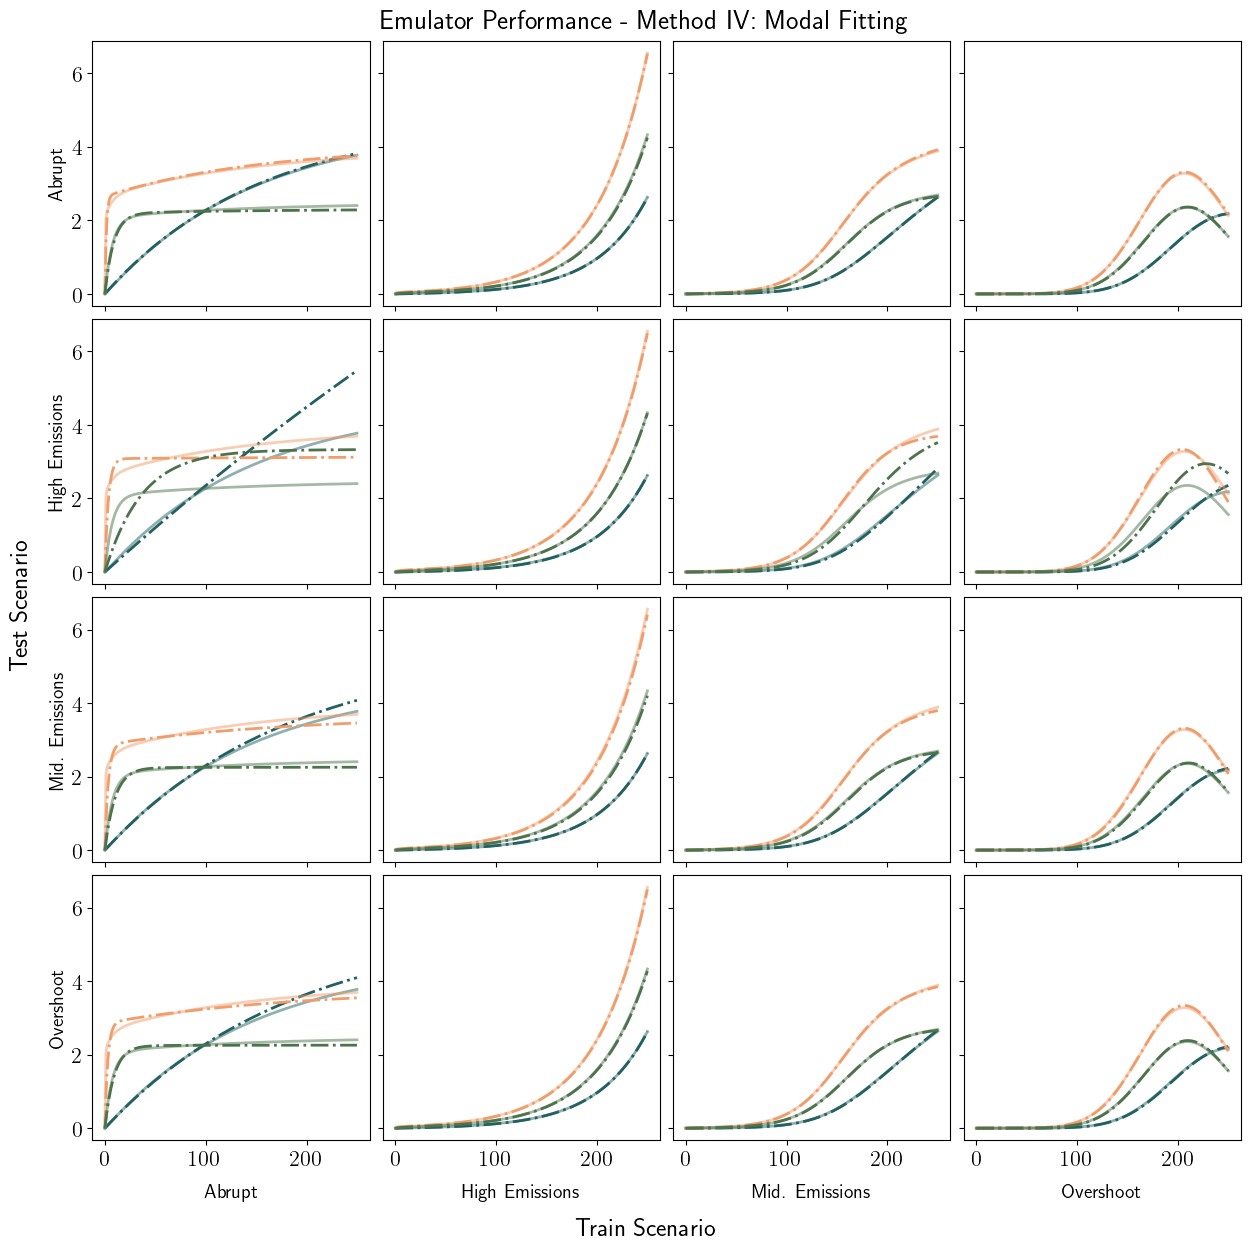

In [7]:
verbose    = True   # Show error output and optimal parameters
plot       = True   # Plot emulator performance
save_error = False  # Save error output

dt = 1 # Timestep (year)
operator_modal, T_pred_modal, error_metrics_modal = utils_emulator.emulate_scenarios('modal', scenarios=scenarios, outputs=T_out, forcings=forcings, t=t, dt=dt, n_boxes=n_boxes, n_modes=3, B=np.ones(n_boxes), verbose=verbose)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_modal, scenarios, operator='modal')

if save_error:
  utils_emulator.save_results(error_metrics_modal, 'exp1_IV_modal_error')

### Method V: Dynamic Mode Decomposition (DMD)

Train: Abrupt - NRMSE
	Test: Abrupt - [0.00333889 0.06159205 0.00868862]
	Test: High Emissions - [1.62775538 2.07096388 1.63322062]
	Test: Mid. Emissions - [1.02987164 0.86652717 0.71699551]
	Test: Overshoot - [1.09375195 1.301487   1.05409399]
Train: High Emissions - NRMSE
	Test: Abrupt - [13.8360386   2.1748573   1.42570056]
	Test: High Emissions - [0.51449232 0.05384349 0.05649689]
	Test: Mid. Emissions - [3.23450169 1.0594434  0.44328318]
	Test: Overshoot - [4.76288309 1.90113601 0.83730274]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [2.14292334 1.12354455 1.6530422 ]
	Test: High Emissions - [1.20506554 0.20985089 0.21239068]
	Test: Mid. Emissions - [0.40654704 0.07122699 0.08375886]
	Test: Overshoot - [0.65295155 0.13702343 0.20432782]
Train: Overshoot - NRMSE
	Test: Abrupt - [4.33502326 1.77165707 2.11218251]
	Test: High Emissions - [0.93822635 0.15472981 0.1572308 ]
	Test: Mid. Emissions - [0.57912094 0.11050845 0.14832529]
	Test: Overshoot - [0.6363066  0.10853152 0.12412265

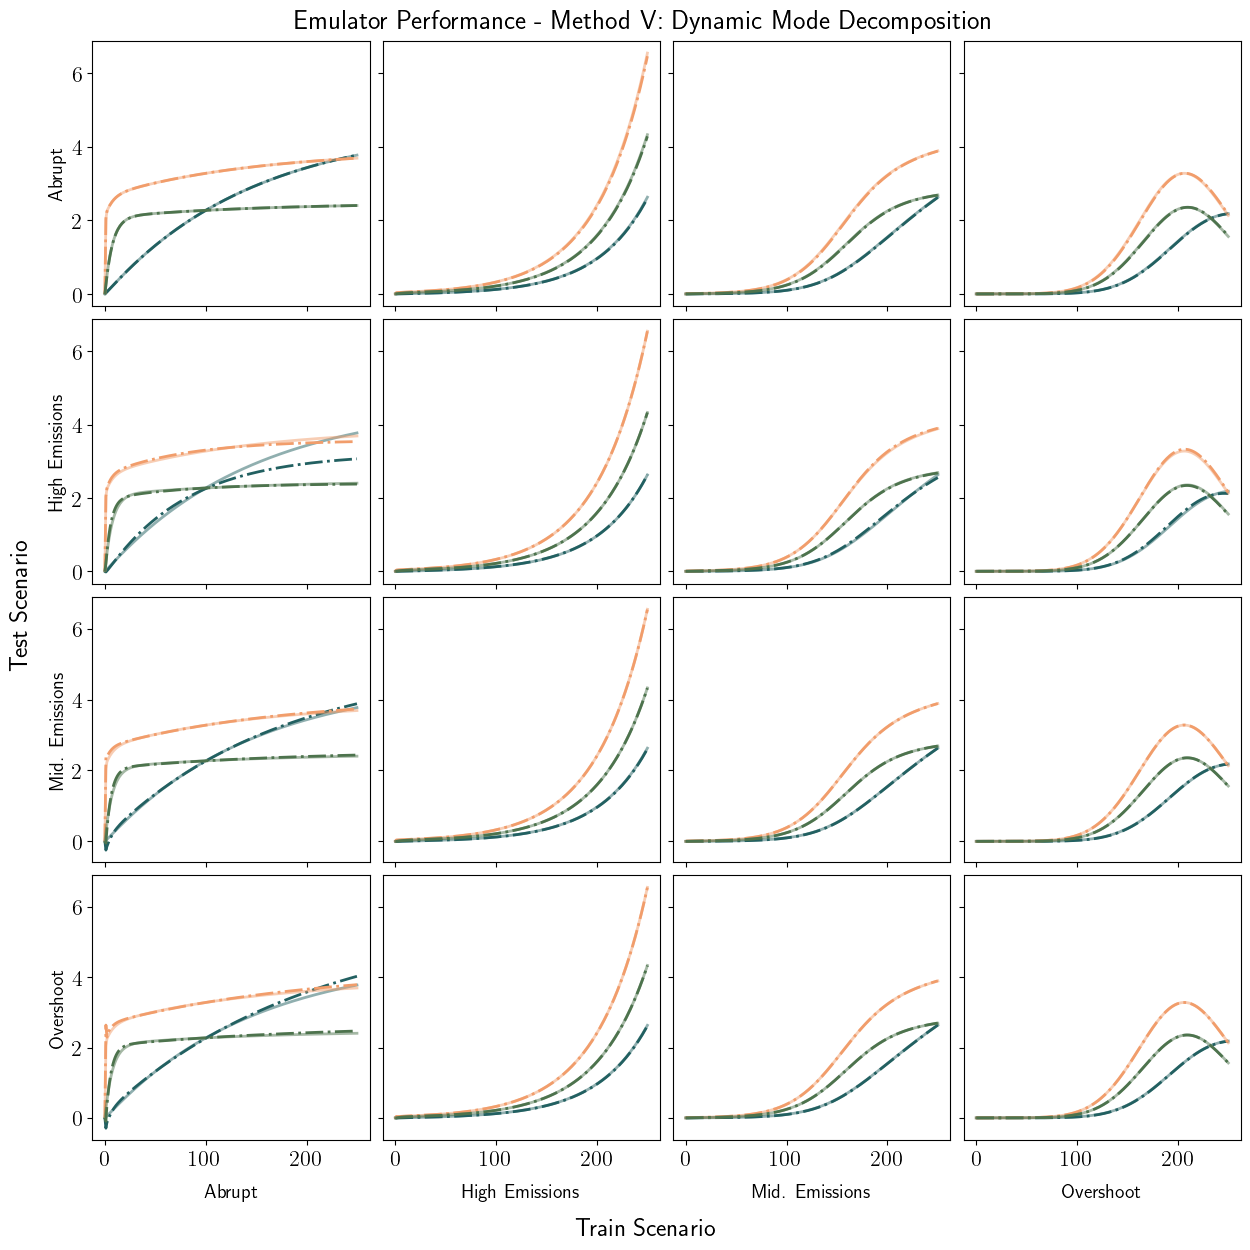

In [9]:
verbose    = True   # Show error output and optimal parameters
plot       = True   # Plot emulator performance
save_error = False  # Save error output

n_steps = len(t)            # No. timesteps
w0      = np.zeros(n_boxes) # Initial condition
operator_DMD, T_pred_DMD, error_metrics_DMD = utils_emulator.emulate_scenarios('DMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t, n_steps=n_steps, n_boxes=n_boxes,regularize=True)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_DMD, scenarios, operator='DMD')

if save_error:
  utils_emulator.save_results(error_metrics_DMD, 'exp1_V_DMD_error')

### Method VI: Extended DMD

Train: Abrupt - NRMSE
	Test: Abrupt - [0.00296152 0.06159153 0.00852262]
	Test: High Emissions - [1.6259105  2.07072373 1.63285122]
	Test: Mid. Emissions - [1.02798872 0.86637241 0.71694335]
	Test: Overshoot - [1.09181768 1.30143912 1.05364343]
Train: High Emissions - NRMSE
	Test: Abrupt - [23.35654227  4.02340317  2.74587283]
	Test: High Emissions - [0.78394428 0.08311319 0.0891219 ]
	Test: Mid. Emissions - [6.2824711  1.00516534 1.31222198]
	Test: Overshoot - [8.48549929 1.89766959 2.17653294]
Train: Mid. Emissions - NRMSE
	Test: Abrupt - [2.35843918 1.05789147 1.92041058]
	Test: High Emissions - [1.52685486 0.24940048 0.23583495]
	Test: Mid. Emissions - [0.50659406 0.08391623 0.09455871]
	Test: Overshoot - [0.80716335 0.152022   0.22553953]
Train: Overshoot - NRMSE
	Test: Abrupt - [4.76444147 1.67362467 2.41322586]
	Test: High Emissions - [1.1735796  0.18291088 0.17691749]
	Test: Mid. Emissions - [0.69858841 0.12722102 0.16965889]
	Test: Overshoot - [0.7586556  0.12721885 0.14064964

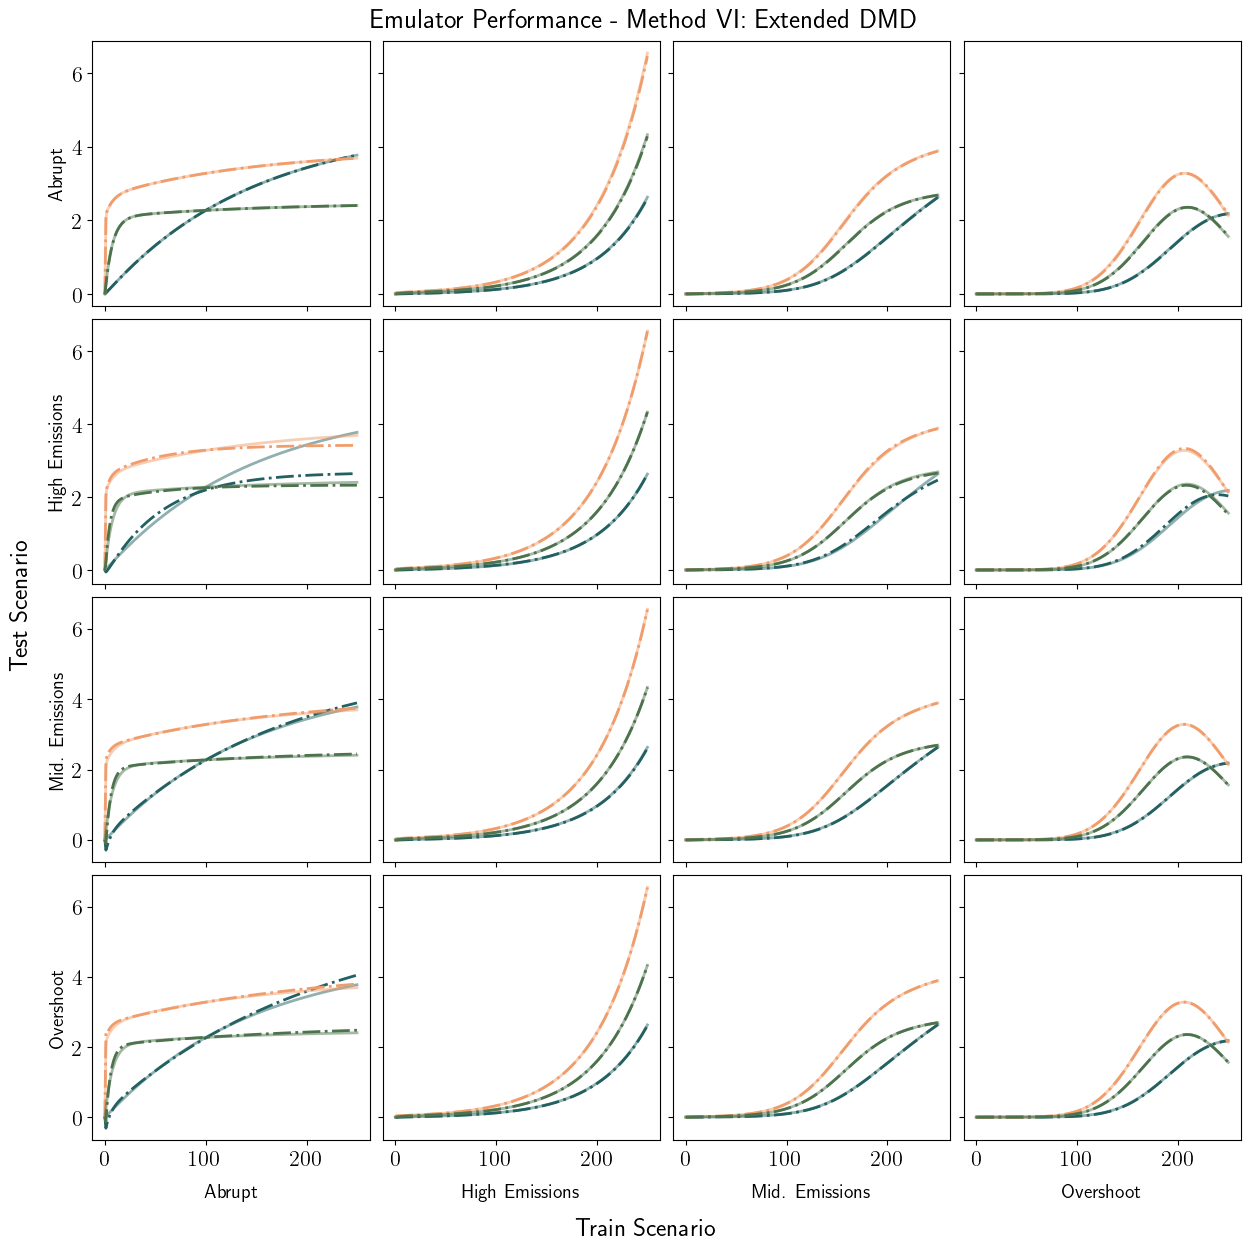

In [9]:
verbose    = True   # Show error output and optimal parameters
plot       = True   # Plot emulator performance
save_error = False  # Save error output

n_steps = len(t)            # No. timesteps
w0      = np.zeros(n_boxes) # Initial condition

# Basis functions
w_dict = utils_emulator.Vector_Dict(method='hermite', degree=1)
F_dict = utils_emulator.Vector_Dict(method='hermite', degree=1)
operator_EDMD, T_pred_EDMD, error_metrics_EDMD = utils_emulator.emulate_scenarios('EDMD', scenarios=scenarios, outputs=T_out, forcings=forcings, w0=w0, t=t,
                                                                n_steps=n_steps, n_boxes=n_boxes, w_dict=w_dict, F_dict=F_dict, regularize=True)

if plot:
  utils_emulator.plot_true_pred(T_out, T_pred_EDMD, scenarios, operator='EDMD')

if save_error:
  utils_emulator.save_results(error_metrics_EDMD, 'exp1_VI_EDMD_error')